<a href="https://colab.research.google.com/github/asgutierrt/Introduction_to_IA/blob/main/unsupervised/no_supervisado_dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# instalar e importar las librerias necesarias
# data
from sklearn import datasets
import numpy as np
from itertools import product

# plotting
import matplotlib.pyplot as plt
# interactive plots
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default='colab'

%pip install babyplots
import babyplots as bp

Note: you may need to restart the kernel to use updated packages.


In [157]:
from os.path import join
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
def encode_array (x):
  enc = OneHotEncoder(handle_unknown='ignore')
  return enc.fit_transform(x.reshape((-1,1))).toarray()

filename = 'water_potability'

# store info on report folder
fig_path= join('..','reports','figures')
results_path= join('..','reports','group_matrix')
filepath = join('..','data',filename)

if filepath.split(".")[-1]=='json':
    df = pd.read_json(filepath, orient="table")
    data = df.iloc[:,:-1].to_numpy()
elif filepath.split(".")[-1]=='txt':
    df = pd.read_csv(filepath, sep='\t')
    data = df.iloc[:,:-1].to_numpy()
elif filepath.split(".")[-1]=='csv':
    df = pd.read_csv(filepath)
    data = df.iloc[:,:-1].to_numpy()
else: #'iris'
    iris = datasets.load_iris()
    df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target']) 

df.shape

(150, 5)

In [158]:
encode_cols=[] #['target']  ['Potability']
df_encoded = pd.get_dummies(df, columns=encode_cols)
df_encoded

# get data
X = df_encoded.iloc[:,:-1].to_numpy()
X = (X-np.min(X,axis=0))/(np.max(X,axis=0)-np.min(X,axis=0)) # normalizar
m=len(X[0]); N=len(X)

X.shape

(150, 4)

# aux functions

In [159]:
# calcular diferentes normas
def norma (X,Y,norma='euclidea',cov_i=''):
    if norma=='coseno':
        num=np.matmul(X,Y)
        den=np.linalg.norm(X,ord=2)*np.linalg.norm(Y,ord=2)
        return 1-num/den
    if norma=='mahalanobis': return np.sqrt((X-Y).dot(cov_i).dot((X-Y).T))
    if norma=='manhattan': p=1
    if norma=='euclidea': p=2
    if norma=='Lp': p=p
    return (abs(X-Y)**p).sum()**(1/p)

def generate_D(X,Y,cov_i):
  norms=['euclidea','mahalanobis','coseno','manhattan']
  Ds=np.zeros(shape=(len(norms),len(X),len(Y)))
  for i,norm in enumerate(norms):
    Ds[i]=np.array([norma(x,y,norma=norm,cov_i=cov_i) for x in X for y in Y]).reshape(len(X),-1)
  return Ds, norms

def plot_distances(Ds, norms, name):
    nrows=2; ncols=2
    fig=plt.figure(figsize=(9,7))
    for i in range(len(norms)):
        ax=plt.subplot(nrows,ncols,i+1)
        cax=ax.matshow(Ds[i], cmap=plt.cm.Blues.reversed(), aspect='auto')
        ax.set_title(norms[i])
        fig.colorbar(cax, ax=ax,fraction=0.046)
    plt.tight_layout(); fig.savefig(name)

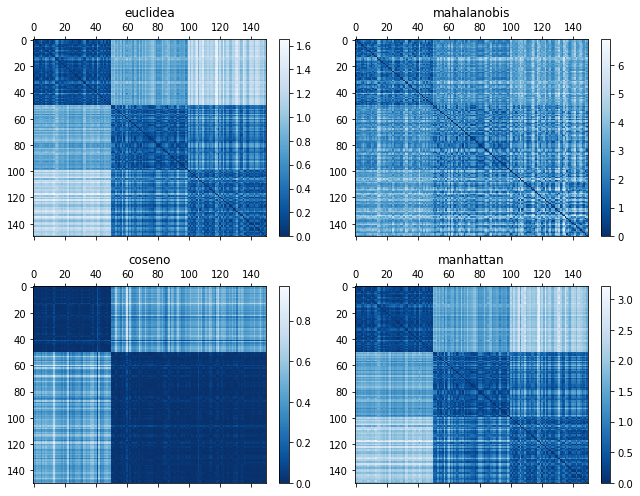

In [160]:
# calcular covarianza
cov=np.cov(X,rowvar=False); cov_i=np.linalg.pinv(cov) # covarianza

# plot distances
D, normas = generate_D(X,X,cov_i)
plot_distances(D, normas, join(fig_path,'distances_XX.png'))

In [161]:
def plot_clusters (X,G0,plot_dims,annotations=[],norma='',html_name='fig.html'):
  # plot all subsets on G0 on the same figure
  fig = go.Figure()

  # especial formating in case of subset overlap
  subset_overlap = sum(G0.sum(axis=1)!=1)!=0
  marker_symbol='circle-open' if subset_overlap else 'circle'
  marker_size = lambda i: i+5 if subset_overlap else 5

  n_subsets=G0.shape[1]
  for i in range(n_subsets):
    subset_filter=G0[:,i].astype(bool)
    fig.add_scatter3d(x=X[subset_filter,plot_dims[0]], y=X[subset_filter,plot_dims[1]], z=X[subset_filter,plot_dims[2]],
                      mode='markers',
                      marker=dict(color=[i+1]*sum(subset_filter),colorscale='Viridis', opacity=1, cmin=0.8, cmax=n_subsets),
                      marker_symbol=marker_symbol, marker_size=marker_size(i),
                      name='data points')

  # annotate points
  if annotations!=[]:
    fig.add_scatter3d(x=X[annotations,plot_dims[0]], y=X[annotations,plot_dims[1]], z=X[annotations,plot_dims[2]],
                      mode='markers+text', marker=dict(color='red'), marker_size=4, text=['x[%i]'%n for n in annotations],
                      name='annotations')

  # tight layout
  titulo='naive classes with norm %s: ir cambiando el punto de referencia'%norma
  fig.update_layout(title_text=titulo, showlegend=False, margin=dict(l=0, r=0, t=40, b=0))
  fig.write_html(html_name)
  return fig

def subplots(X,G0_list,plot_dims,annotations_list,norm,html_name='fig.html'):
  n_subplots = len(G0_list)
  fig = make_subplots(rows=1, cols=n_subplots, specs=[[{'type': 'surface'}]*n_subplots],
                    subplot_titles=(range(1,n_subplots+1)))

  for fig_ix in range(n_subplots):
    sub_fig = plot_clusters(X,G0_list[fig_ix],plot_dims,annotations=annotations_list[fig_ix],norma=norm)
    for trace in sub_fig.data:
      fig.add_trace(trace, row=1, col=fig_ix+1)

  # tight layout
  fig.for_each_annotation(lambda a: a.update(text = "x[%s] as reference"%annotations_list[int(a.text)-1][0]))
  fig.update_layout(autosize=True, title_text='naive classes with norm %s: crear todas las cajas desde un unico punto de referencia'%norm, showlegend=False)
  fig.write_html(html_name)
  return fig

# naive algs

In [162]:
def threshold_distance(x,n_groups):
    # threshold defined by number of groups
    return x/((x.max()+10**-10-x.min())/n_groups)

def unclassified_points(points,G0):
    return np.ma.masked_array(points, (G0.sum(axis=1)!=0))

In [164]:
# naive clustering
norm_ix=0 # which distance matrix
n_groups=3 # number of groups

G=np.apply_along_axis(threshold_distance, 1, D[norm_ix], n_groups=n_groups).astype(int)

# pick one clustering and plot
x_ref=0
G0 = encode_array(G[x_ref])

#fig = plot_clusters (X,G0,[0,1,2],annotations=[x_ref],norma=norms[norm_ix])

x_references=[0,50,25]
fig=subplots(X,[encode_array(G[x]) for x in x_references],[0,1,2],[[x] for x in x_references],norms[norm_ix])
fig.show()

NameError: name 'norms' is not defined

In [ ]:
# naive boxes
norm_ix=3; n_groups=3

# clasificar segun la distancia a cada punto (150 clasificaciones)
G_threshold=np.apply_along_axis(threshold_distance, 0, D[norm_ix].flatten(),
                                    n_groups=n_groups).reshape((len(X),-1))

# clasificacion en cajas
x_ref=0; ref_points=[]
G0=np.zeros(shape=(len(X),n_groups))
for i in range(n_groups):
  # group all points close to x_ref together (valor menor a 1 en la matriz G)
  ref_points.append(x_ref)
  mask=G_threshold[x_ref]<1
  G0[mask,i]=1

  # pick the next closest point that is not yet classified and make it the next reference point
  x_ref=unclassified_points(G_threshold[x_ref],G0).argmin()

fig=plot_clusters (X,G0,[0,1,2],annotations=ref_points,norma=normas[norm_ix])
fig

In [ ]:
# naive clustering (k-vecinos no supervisado)
# which distance matrix
norm_ix=3; k_n=50

# sorted indixes
D_sorted_ix=np.argsort(D[norm_ix],axis=1)

x_ref=0; ref_points=[]
G0=np.zeros(shape=(len(X),len(X))) # group assignment matrix: theres is a maximum os subsets equal to the number of points

end_kn=False; i=0
while not bool(end_kn):
  # group points close to x_ref together
  ref_points.append(x_ref)
  mask=D_sorted_ix[x_ref][:k_n]
  G0[mask,i]=1

  # find which point has not been assigned to any group and is closest to x_ref
  # make it the next reference point
  for x_ref in D_sorted_ix[x_ref][k_n:]: # explore if other close neighbors have not been assigned
      end_kn=True
      if G0[x_ref].sum()==0:
          end_kn=False; break
  i+=1

G0=G0[:,:len(ref_points)] # drop unnecesary columns

fig=plot_clusters (X,G0,[0,1,2],annotations=ref_points,norma=normas[norm_ix])
fig

<ipython-input-139-416eed64d1bc>:6: RuntimeWarning:

invalid value encountered in double_scalars



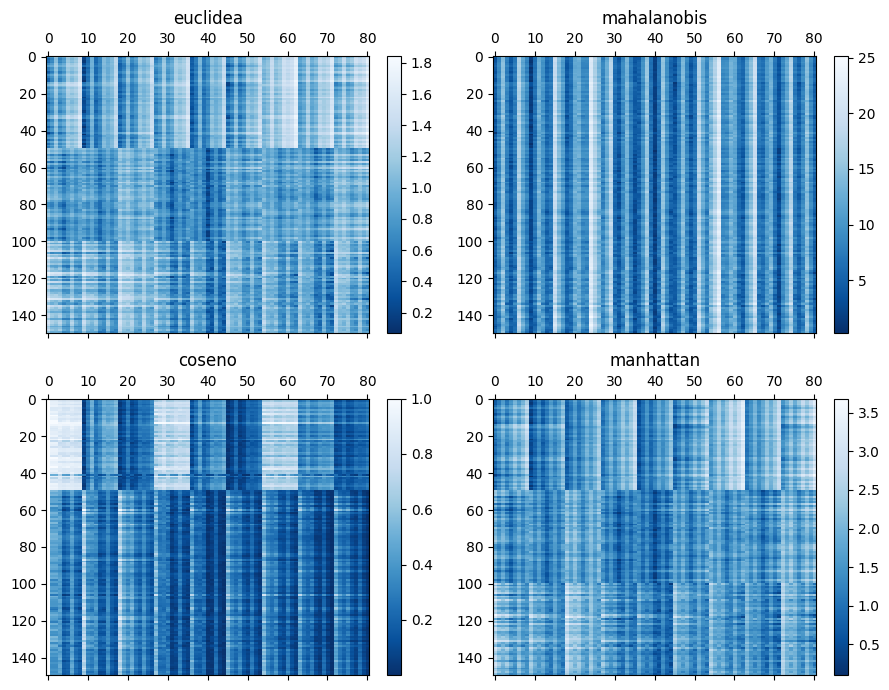

In [ ]:
# make grid
malla=lambda m, n_intervals: np.array(list(product(np.arange(n_intervals +1)*1/n_intervals,repeat=m)))
n_grid_intervals= lambda N,m: int(np.exp(np.log(N)/m)-1)
grid=malla(m,n_grid_intervals(N,m))

# plot distances
Ds, norms = generate_D(X,grid,cov_i)
plot_distances(Ds, norms, 'distances_vX.png')

In [ ]:
fig = go.Figure()

fig.add_scatter3d(x=X[:,0], y=X[:,1], z=X[:,2],
                  mode='markers',
                  marker=dict(size=5,color='mediumblue'), name='data points')

fig.add_scatter3d(x=grid[:,0], y=grid[:,1], z=grid[:,2],
                  mode='markers', marker=dict(size=5, color='purple'), name='grid points')

# tight layout
fig.update_layout(title_text='naive classes with norm %s: ir cambiando el punto de referencia'%norms[norm_ix], showlegend=False, margin=dict(l=0, r=0, t=40, b=0))
fig.show()

In [ ]:
# readme, requirements.txt: funcionalidad de todo: main (entradas al sistema: archivo de datos), funciones en carpeta src,
# path automatico
# ejm. santiago hincapie, alejandro murillo
# documentar cada funcion y el codigo


In [ ]:
# 5 tipos de clustering en Rn con iris dataset
# 1. leer el archivo: preguntar tipo de archivo (csv,txt,json,xlsx,xls), almacenarlo.
# 1.a. variables categoricas a numericas: crear columnas binarias - onehot encoding
# 2. clustering: matrices de distancias, cajas y k=ki vecinos
# 2.a. n_conjuntos: depende de la segmentacion, parametro default k
# 2.output. matriz Nxki con {0,1}
# - cuenta de a cuales grupos perteneces


In [ ]:
# densidad
# definir la forma del cluster
# subconjunto:
